In [1]:
%matplotlib inline
import torch
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import torchvision
import torchvision.transforms as transforms
from torch.autograd import Variable
from torch.autograd import Function
import torch.nn as nn
import torch.nn.functional as F
import copy

In [2]:
transform = transforms.Compose([transforms.ToTensor()])
BatchSize = 1000

trainset = torchvision.datasets.MNIST(root='/content/MNIST', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=BatchSize, shuffle=True, num_workers=4)

testset = torchvision.datasets.MNIST(root='/content/MNIST', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=BatchSize, shuffle=False, num_workers=4)

classes = ('zero', 'one', 'two', 'three', 'four', 'five', 'six', 'seven', 'eight', 'nine')

100%|██████████| 9.91M/9.91M [00:02<00:00, 4.75MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 129kB/s]
100%|██████████| 1.65M/1.65M [00:01<00:00, 1.18MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 9.11MB/s]
/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [3]:
use_gpu = torch.cuda.is_available()
if use_gpu:
    print('GPU is available')

GPU is available


# Defining the SAE

In [4]:
class L1Penalty(Function):

    @staticmethod
    def forward(ctx, input, l1weight):
        ctx.save_for_backward(input)
        ctx.l1weight = l1weight
        return input

    @staticmethod
    def backward(ctx, grad_output):
        input, = ctx.saved_tensors
        grad_input = input.clone().sign().mul(ctx.l1weight)
        grad_input += grad_output
        return grad_input, None # Return None for the gradient of l1weight

In [5]:
class autoencoder(nn.Module):
    def __init__(self):
        super(autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(28*28, 400),
            nn.Tanh()
        )

        self.decoder = nn.Sequential(
            nn.Linear(400, 28*28),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = L1Penalty.apply(x, 0.1)
        x = self.decoder(x)
        return x

net = autoencoder()
print(net)

autoencoder(
  (encoder): Sequential(
    (0): Linear(in_features=784, out_features=400, bias=True)
    (1): Tanh()
  )
  (decoder): Sequential(
    (0): Linear(in_features=400, out_features=784, bias=True)
    (1): Sigmoid()
  )
)


In [6]:
if use_gpu:
    net = net.double().cuda()
else:
    net = net.double()

init_weightsE = copy.deepcopy(net.encoder[0].weight.data)
init_weightsD = copy.deepcopy(net.decoder[0].weight.data)

# Train Autoencoder

In [17]:
iterations = 20
learning_rate = 0.98
criterion = nn.MSELoss()

dataiter = iter(testloader)
images, labels = next(dataiter)
printImg = torch.Tensor(iterations // 10, 2, 1, 28, 28)

for epoch in range(iterations):
    runningLoss = 0.0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        if use_gpu:
            inputs = Variable(inputs.view(-1, 28*28).double()).cuda()
        else:
            inputs = Variable(inputs.view(-1, 28*28).double())
        net.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, inputs)
        loss.backward()
        for f in net.parameters():
            f.data.sub_(f.grad.data * learning_rate)
        runningLoss += loss.item()

    print('[%d] loss: %.3f' % (epoch + 1, runningLoss / len(trainloader)))

    if epoch % 10 == 0:
        if use_gpu:
            outImg = net(Variable((images[0].view(-1, 28*28).double().cuda())))
            outImg = outImg.view(-1, 28, 28).cpu()
        else:
            outImg = net(Variable((images[0].view(-1, 28*28).double())))
            outImg = outImg.view(-1, 28, 28)
        printImg[epoch // 10] = torch.cat([images[0].unsqueeze(0), outImg.unsqueeze(0)], dim=0) # Corrected this line
print('Finished Training')

/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


[1] loss: 0.059
[2] loss: 0.059
[3] loss: 0.059
[4] loss: 0.058
[5] loss: 0.058
[6] loss: 0.058
[7] loss: 0.058
[8] loss: 0.058
[9] loss: 0.057
[10] loss: 0.057
[11] loss: 0.057
[12] loss: 0.057
[13] loss: 0.056
[14] loss: 0.056
[15] loss: 0.056
[16] loss: 0.056
[17] loss: 0.056
[18] loss: 0.055
[19] loss: 0.055
[20] loss: 0.055
Finished Training


# Autoencoder Perfomance

In [18]:
def imshow(img, strlabel):
    npimg = img.numpy()
    npimg = np.abs(npimg)
    fig_size = plt.rcParams["figure.figsize"]
    fig_size[0] = 10
    fig_size[1] = 10
    plt.rcParams["figure.figsize"] = fig_size
    plt.figure()
    plt.title(strlabel)
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

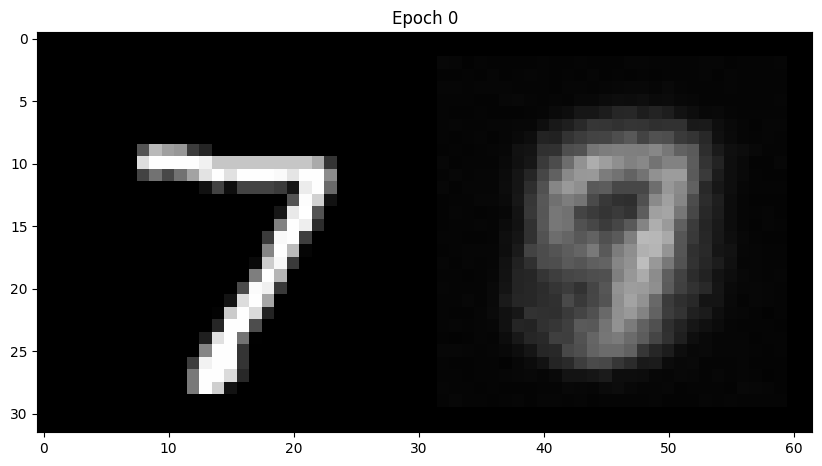

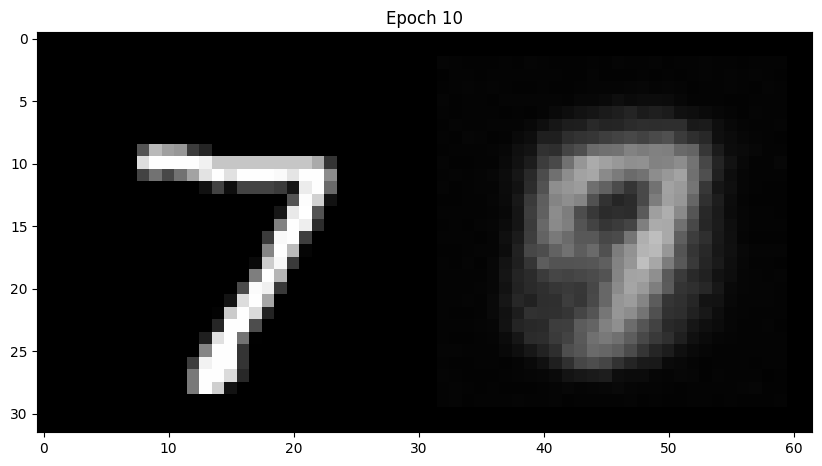

In [19]:
for i in range(iterations//10):
    imshow(torchvision.utils.make_grid(printImg[i]), 'Epoch ' + str(i*10))

# Encoder Weight Visualization

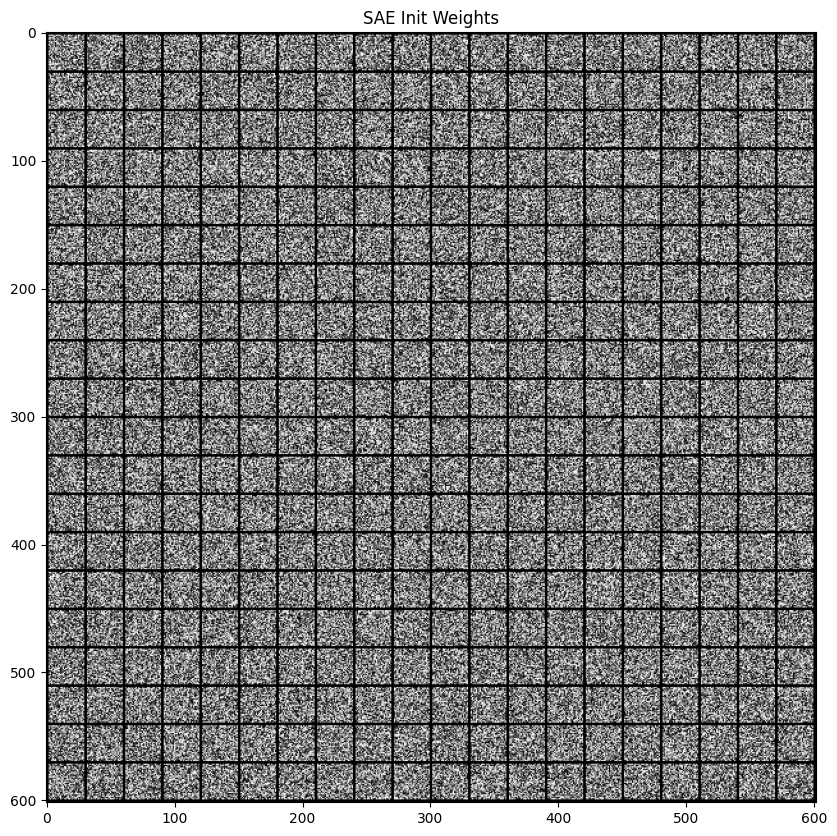

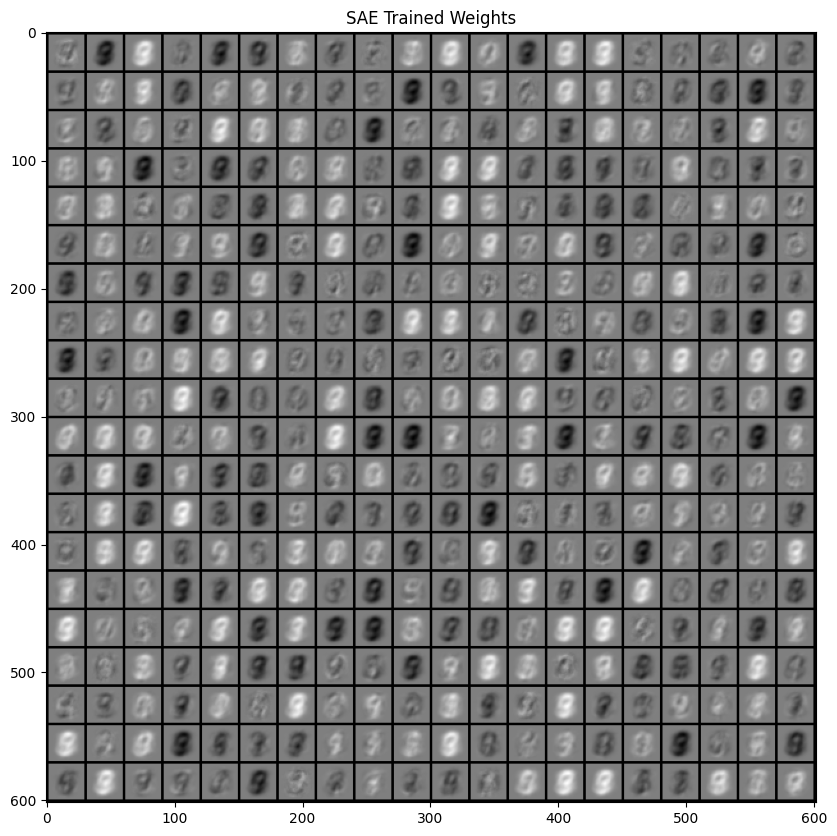

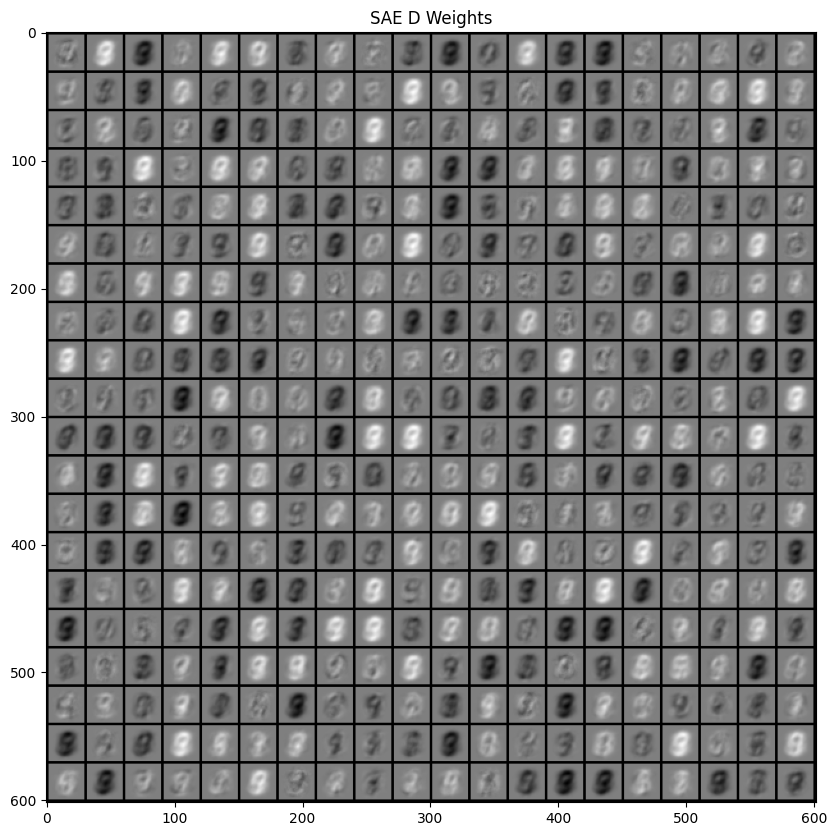

In [21]:
trained_weightsE = copy.deepcopy(net.encoder[0].weight.data)
if use_gpu:
    trained_weightsE = trained_weightsE.cpu()  # Move to CPU before subtraction

# Explicitly reshape to ensure correct shape before subtraction
init_weightsE = init_weightsE.view(400, 784)
trained_weightsE = trained_weightsE.view(400, 784)

d_weightsE = init_weightsE - trained_weightsE

if use_gpu:
    init_weightsE = init_weightsE.view(400, 1, 28, 28).cpu()
    trained_weightsE = trained_weightsE.view(400, 1, 28, 28).cpu()
    d_weightsE = d_weightsE.view(400, 1, 28, 28).cpu()
else:
    init_weightsE = init_weightsE.view(400, 1, 28, 28)
    trained_weightsE = trained_weightsE.view(400, 1, 28, 28)
    d_weightsE = d_weightsE.view(400, 1, 28, 28)

imshow(torchvision.utils.make_grid(init_weightsE, nrow=20, normalize=True), 'SAE Init Weights')
imshow(torchvision.utils.make_grid(trained_weightsE, nrow=20, normalize=True), 'SAE Trained Weights')
imshow(torchvision.utils.make_grid(d_weightsE, nrow=20, normalize=True), 'SAE D Weights')